In [93]:
import numpy as np
import scipy as sp
                       
import matplotlib.pyplot as plt
%matplotlib inline

import os
import re
from IPython.display import clear_output

import pennylane as qml
from pennylane import expval, var

import torch
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F

In [12]:
%load_ext autoreload
%autoreload 2

## Constants

In [13]:
n_qubits = 2
n = n_qubits

n_train = 200
n_test = 500

In [14]:
data_folder = "data/{}q".format(n_qubits)

## State preparation

In [15]:
dev = qml.device('default.qubit', wires=3)
dev.shots = 500

### Definition of the circuit

In [16]:
def universal_block(params, q):
    qml.RZ(params[0], wires=q[0])
    qml.RY(params[1], wires=q[0])
    qml.RZ(params[2], wires=q[0])
    qml.RZ(params[3], wires=q[1])
    qml.RY(params[4], wires=q[1])
    qml.RZ(params[5], wires=q[1])
    qml.CNOT(wires=[q[1],q[0]])
    qml.RZ(params[6], wires=q[0])
    qml.RY(params[7], wires=q[1])
    qml.CNOT(wires=[q[0],q[1]])
    qml.RY(params[8], wires=q[1])
    qml.CNOT(wires=[q[1],q[0]])
    qml.RZ(params[9], wires=q[0])
    qml.RY(params[10], wires=q[0])
    qml.RZ(params[11], wires=q[0])
    qml.RZ(params[12], wires=q[1])
    qml.RY(params[13], wires=q[1])
    qml.RZ(params[14], wires=q[1])

In [17]:
@qml.qnode(dev, interface='torch')
def sp_energy(sp_params):
    wires = [1,2]
    universal_block(sp_params, wires)
    Z = np.array([[1, 0], [0, -1]])
    H = np.kron(Z, Z)
    return qml.expval(qml.Hermitian(H, wires))

### Creation of the dataset

In [18]:
sp_params_train = np.random.choice([0, np.pi/2, -np.pi/2, np.pi], size=(n_train, 15))
sp_params_test = np.random.uniform(-np.pi,np.pi, size=(n_test, 15))

In [19]:
def create_balanced_dataset(n, clifford=True, delta=0.2):
    sp_params = []
    for E_low in np.arange(-1, 1, delta):
        cur_params = []
        size_subset = int(n // (2 / delta))
        while (len(cur_params) <= size_subset):
            if clifford:
                p = np.random.choice([0, np.pi/2, -np.pi/2, np.pi], size=(200, 15))
            else:
                p = np.random.uniform(-np.pi,np.pi, size=(200, 15))
            E = list(map(lambda x: float(sp_energy(x).detach().numpy()), p))
            correct_indices = np.logical_and(E_low <= E, E <= E_low + delta)
            if len(cur_params) == 0:
                cur_params = p[correct_indices]
            else:
                cur_params = np.concatenate([cur_params, p[correct_indices]])
            clear_output(wait=True)
            print("E low", E_low, ", ", len(cur_params))
        cur_params = cur_params[:size_subset]
        if len(sp_params) == 0:
            sp_params = cur_params
        else:
            sp_params = np.concatenate([sp_params, cur_params])
    return sp_params

In [20]:
sp_params_train = create_balanced_dataset(n_train, True, 0.5)
sp_params_test = create_balanced_dataset(n_test, False)

E low 0.7999999999999996 ,  52


In [21]:
energies_train = list(map(lambda x: float(sp_energy(x).detach().numpy()), sp_params_train))
energies_test = list(map(lambda x: float(sp_energy(x).detach().numpy()), sp_params_test))

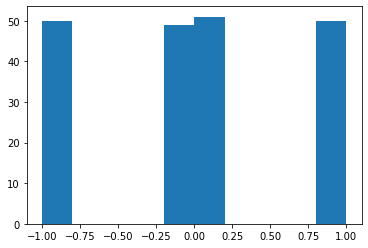

In [22]:
plt.hist(energies_train);

### Test of the dataset

In [23]:
@qml.qnode(dev, interface='torch')
def sp_network(sp_params):
    universal_block(sp_params, [1, 2])
    return (qml.sample(qml.PauliZ(1)), qml.sample(qml.PauliZ(2)))

Counter({(1.0, -1.0): 144, (-1.0, -1.0): 139, (-1.0, 1.0): 109, (1.0, 1.0): 108})


([<matplotlib.axis.XTick at 0x12722f0d0>,
 <a list of 4 Text xticklabel objects>)

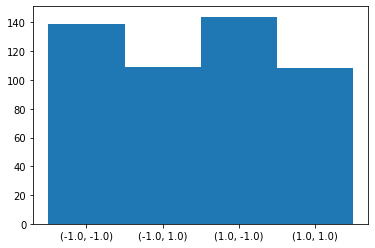

In [24]:
from collections import Counter

i = 25
measures = sp_network(sp_params_test[i]).detach().numpy()
list_measures = list(zip(list(measures[0]), list(measures[1])))
c = Counter(list_measures)
print(c)

x = range(len(c))
y = [c[key] for key in sorted(c)]
xlabels=[str(t) for t in sorted(c)]
plt.bar(x,y,width=1)
plt.xticks([x for x in x],xlabels)

## Variational circuit

### Main blocks

In [25]:
def CCNOT(wires):
    U = np.eye(8)
    U[-2:, -2:] = np.array([[0, 1], [1, 0]])
    qml.QubitUnitary(U, wires=wires)

In [26]:
def controlled_block(params):
    qml.CRZ(params[0], wires=[0, 1])
    qml.CRY(params[1], wires=[0, 1])
    qml.CRZ(params[2], wires=[0, 1])
    
    qml.CRZ(params[3], wires=[0, 2])
    qml.CRY(params[4], wires=[0, 2])
    qml.CRZ(params[5], wires=[0, 2])
    
    CCNOT(wires=[0, 2, 1])
    qml.CRZ(params[6], wires=[0, 1])
    qml.CRY(params[7], wires=[0, 2])
    
    CCNOT(wires=[0, 1, 2])
    qml.CRY(params[8], wires=[0, 2])
    CCNOT(wires=[0, 2, 1])
    
    qml.CRZ(params[9], wires=[0, 1])
    qml.CRY(params[10], wires=[0, 1])
    qml.CRZ(params[11], wires=[0, 1])
    
    qml.CRZ(params[12], wires=[0, 2])
    qml.CRY(params[13], wires=[0, 2])
    qml.CRZ(params[14], wires=[0, 2])

### Composition

In [27]:
@qml.qnode(dev, interface='torch')
def total_qnn(sp_params, qnn_params):
    universal_block(sp_params, [1, 2])
    qml.Hadamard(0)
    controlled_block(qnn_params)
    qml.Hadamard(0)

    return qml.expval.PauliZ(0)

In [28]:
qnn_params = torch.tensor(np.random.normal(size=15, scale=1), requires_grad=True)
end_params = torch.tensor(np.array([1., 0.]), requires_grad=True)

In [29]:
total_qnn(torch.tensor(sp_params_train[5]), qnn_params)

tensor(0.4960, dtype=torch.float64, grad_fn=<_TorchQNodeBackward>)

In [30]:
def total_network(sp_params, qnn_params, end_params):
    return end_params[0] * total_qnn(sp_params, qnn_params) + end_params[1]

In [31]:
total_network(torch.tensor(sp_params_train[0]), qnn_params, end_params)

tensor(-0.2520, dtype=torch.float64, grad_fn=<AddBackward0>)

### Cost function

In [73]:
def cost(sp_params, qnn_params, end_params, energy):
    predicted_energy = total_network(sp_params, qnn_params, end_params)
    return (predicted_energy - energy)**2

In [74]:
qnn_params

tensor([-0.1047,  0.1285, -0.1884, -0.0760,  0.0461, -0.0736,  0.1248,  0.0320,
         0.1081,  0.1112, -0.0213, -0.0944,  0.0066,  0.0561, -0.1309],
       dtype=torch.float64, requires_grad=True)

In [75]:
cost(torch.tensor(sp_params_train[0]), qnn_params, end_params, torch.tensor(energies_train[0]))

tensor(1.4787, dtype=torch.float64, grad_fn=<PowBackward0>)

## Training

In [263]:
qnn_params = torch.tensor(np.random.normal(size=15, scale=0.1), requires_grad=True)
end_params = torch.tensor(np.array([1., 0.]), requires_grad=True)

cost_train_list = []
cost_test_list = []
iter_train_list = []
iter_test_list = []
i = 0

In [308]:
qnn_params

tensor([-0.9155,  0.6020, -0.9316,  0.2806,  0.8615,  1.1764,  1.5833, -1.5601,
         1.5576, -0.4969,  0.5955,  0.7977,  0.3642,  0.8749, -0.2658],
       dtype=torch.float64, requires_grad=True)

In [302]:
np.pi/2

1.5707963267948966

In [307]:
end_params

tensor([1.4064, 0.0065], dtype=torch.float64, requires_grad=True)

In [266]:
@qml.qnode(dev)
def total_qnn_notorch(qnn_params):
    universal_block(sp_params.detach().numpy(), [1, 2])
    qml.Hadamard(0)
    controlled_block(qnn_params)
    qml.Hadamard(0)

    return qml.expval.PauliZ(0)

In [267]:
opt = torch.optim.SGD([end_params, qnn_params], lr=1e-3)

In [314]:
n_epochs = 100
n_iters_test = 2
lr = 0.01
lr_ab = 0.01
batch_size = 64
opt.lr = lr

for i in range(i, n_epochs+i):
    samples_idx = np.random.choice(n_train, size=n_train, replace=False)
    
    cost_train_epoch = []
    cost_train_batch = 0
    for i_sample in range(n_train):
        sp_params = torch.tensor(sp_params_train[samples_idx[i_sample]])
        energy = torch.tensor(energies_train[samples_idx[i_sample]])
      
        curr_cost = cost(sp_params, qnn_params, end_params, energy)
        cost_train_batch += curr_cost
#         print(curr_cost)
            
        if (i_sample != 0 and i_sample % batch_size == 0) or i_sample == n_train-1:
            cost_train_batch /= batch_size
            cost_train_epoch.append(cost_train_batch.detach().numpy())
            
            opt.zero_grad()
            cost_train_batch.backward()
            
            clear_output(wait=True)
            print('Step: {}/{}'.format(i_sample, n_train))
            print('Cost train after step {:5d}: {: .10f}'.format(i, np.mean(cost_train_epoch)))
            if i > n_iters_test:
                print('Cost test after step {:5d}: {: .10f}'.format(i, cost_test_list[-1]))
#             print("Gradient before", qnn_params.grad.data)
            print("Gradient after", ginv @ qnn_params.grad.data)
            print(end_params.grad.data)
            
            mt = total_qnn_notorch.metric_tensor(qnn_params.detach().numpy())
            ginv = torch.tensor(sp.linalg.pinvh(mt))
#             print(ginv)
#             qnn_params.grad.data = ginv @ qnn_params.grad.data
            qnn_params.data.sub_(lr * ginv @ qnn_params.grad.data)
            end_params.data.sub_(lr_ab * end_params.grad.data)
#             opt.step()
            cost_train_batch = 0

    if i % n_iters_test == 0:
        print("Testing...")
        samples_idx = np.random.choice(n_test, size=n_test, replace=False)
        cost_test_sample = []
        for i_sample in range(n_test):
            sp_params = torch.tensor(sp_params_test[samples_idx[i_sample]])
            energy = torch.tensor(energies_test[samples_idx[i_sample]])
            cost_test_sample.append(cost(sp_params, qnn_params, end_params, energy).detach().numpy())
        cost_test_list.append(np.mean(cost_test_sample))
        iter_test_list.append(i)

    cost_train_list.append(np.mean(cost_train_epoch))
    iter_train_list.append(i)

i = i+1

Step: 128/200
Cost train after step    62:  0.0036347930
Cost test after step    62:  0.0047974078
Gradient after tensor([ 0.0378,  0.0112,  0.0547,  0.0595,  0.0137,  0.0369, -0.0389, -0.0736,
         0.0032,  0.0606, -0.0036,  0.0314,  0.0372, -0.0027,  0.0576],
       dtype=torch.float64)
tensor([-0.0086,  0.0087], dtype=torch.float64)


KeyboardInterrupt: 

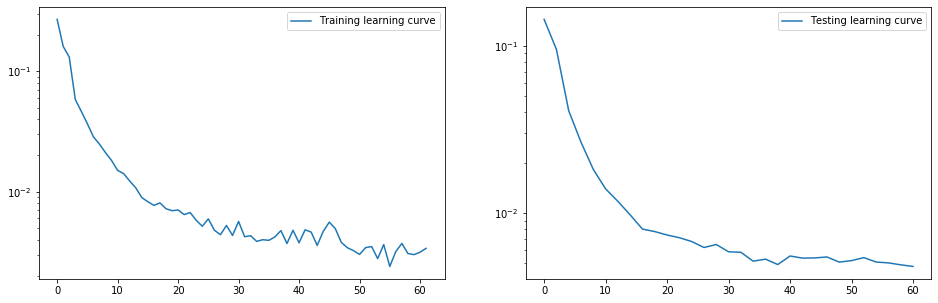

In [315]:
start = 0
plt.rcParams['figure.figsize'] = (16,5)

plt.subplot(1,2,1)
plt.plot(iter_train_list[start:], cost_train_list[start:], 
         label="Training learning curve")
plt.legend()
plt.yscale('log')

plt.subplot(1,2,2)
plt.plot(iter_test_list[np.where(np.array(iter_test_list) >= start)[0][0]:], cost_test_list[np.where(np.array(iter_test_list) >= start)[0][0]:], 
         label="Testing learning curve")
plt.legend()
plt.yscale('log')

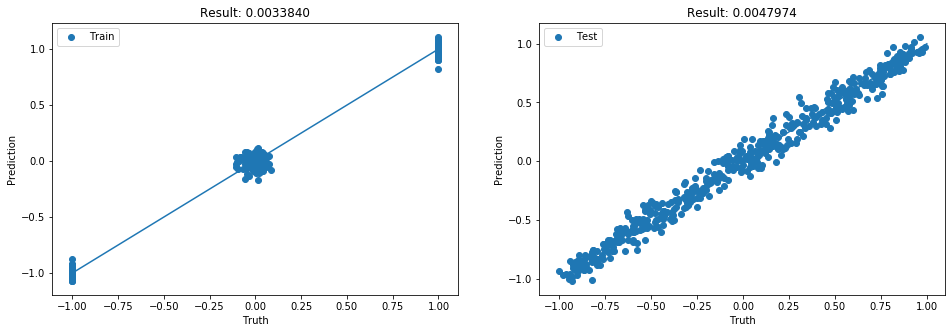

In [316]:
plt.rcParams['figure.figsize'] = (16,5)

plt.subplot(1,2,1)
plt.title("Result: {:0.7f}".format(cost_train_list[-1]))

energy_pred = []
for j in range(n_train):
    sp_params = torch.tensor(sp_params_train[j])
    energy_pred.append(total_network(sp_params, qnn_params, end_params).detach().numpy())

plt.scatter(energies_train, energy_pred, label="Train")
plt.plot([-1,1],[-1,1])
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.legend()

plt.subplot(1,2,2)
plt.title("Result: {:0.7f}".format(cost_test_list[-1]))

energy_pred = []
for j in range(n_test):
    sp_params = torch.tensor(sp_params_test[j])
    energy_pred.append(total_network(sp_params, qnn_params, end_params).detach().numpy())
    
plt.scatter(energies_test, energy_pred, label="Test")
plt.plot([0,1],[0,1])
plt.xlabel("Truth")
plt.ylabel("Prediction")
plt.legend()


tensor([ 1.2619, -0.0941], dtype=torch.float64, requires_grad=True)

In [ ]:
# n_epochs = 100
# n_iters_test = 2
# lr = 0.00001
# lr_ab = 0.00001
# batch_size = 4
# opt.lr = lr

# for i in range(i, n_epochs+i):
#     samples_idx = np.random.choice(n_train, size=n_train, replace=False)
    
#     cost_train_epoch = []
#     cost_train_batch = 0
#     qnn_grad_batch = 0
#     end_grad_batch = 0
#     for i_sample in range(n_train):
#         sp_params = torch.tensor(sp_params_train[samples_idx[i_sample]])
#         energy = torch.tensor(energies_train[samples_idx[i_sample]])
      
#         curr_cost = cost(sp_params, qnn_params, end_params, energy)
#         cost_train_batch += curr_cost
# #         print(curr_cost)
        
#         mt = total_qnn_notorch.metric_tensor(sp_params.detach().numpy(), qnn_params.detach().numpy())
#         ginv = torch.tensor(sp.linalg.pinvh(mt[15:, 15:]))
#         curr_cost.backward()
# #         print("Gradient before", qnn_params.grad.data)
#         print("ginv", ginv)
#         qnn_grad_batch += ginv @ qnn_params.grad.data
#         end_grad_batch += end_params.grad.data
#         opt.zero_grad()
        
#         if (i_sample != 0 and i_sample % batch_size == 0) or i_sample == n_train-1:
#             cost_train_batch /= batch_size
#             cost_train_epoch.append(cost_train_batch.detach().numpy())
#             qnn_grad_batch /= batch_size
#             end_grad_batch /= batch_size
            
#             clear_output(wait=True)
#             print('Step: {}/{}'.format(i_sample, n_train))
#             print('Cost train after step {:5d}: {: .10f}'.format(i, np.mean(cost_train_epoch)))
            
#             if i > n_iters_test:
#                 print('Cost test after step {:5d}: {: .10f}'.format(i, cost_test_list[-1]))
            
#             print("Gradient", qnn_grad_batch)
                    
#             qnn_params.grad.data = qnn_grad_batch
#             end_params.grad.data = end_grad_batch
#             opt.step()
        
#             cost_train_batch = 0
#             qnn_grad_batch = 0
#             end_grad_batch = 0
            
#     if i % n_iters_test == 0:
#         print("Testing")
#         samples_idx = np.random.choice(n_test, size=n_test, replace=False)
#         cost_test_sample = []
#         for i_sample in range(n_test):
#             clear_output(wait=True)
#             sp_params = torch.tensor(sp_params_test[samples_idx[i_sample]])
#             energy = torch.tensor(energies_test[samples_idx[i_sample]])
#             cost_test_sample.append(cost(sp_params, qnn_params, end_params, energy).detach().numpy())
#         cost_test_list.append(np.mean(cost_test_sample))
#         iter_test_list.append(i)

#     cost_train_list.append(np.mean(cost_train_epoch))
#     iter_train_list.append(i)
    
# i = i+1